# RelativisticDynamics.jl demo

This notebook demonstrates how to use the `RelativisticDynamics.jl` package

In [12]:
using Revise
using RelativisticDynamics

---

## 1. Example Orbital Trajectory

The core aim of `RelativisticDynamics.jl` is to be able to accurately describe the spin-orbital evolution of a relativistic system. This can be easily done using the default settings as:

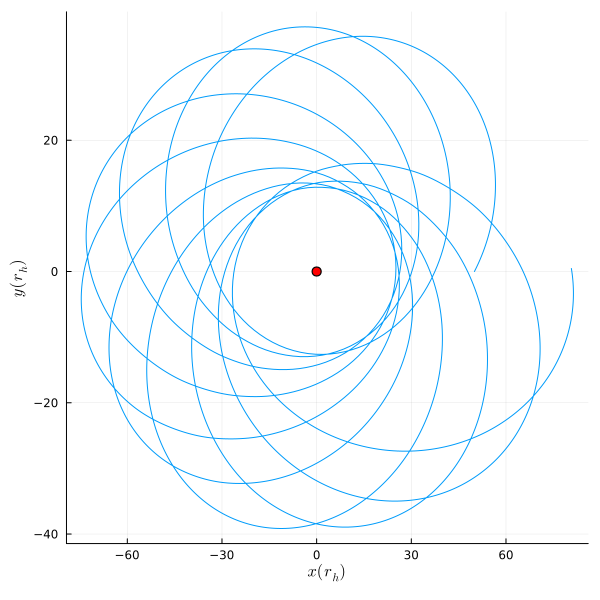

Plotting the solution generated with the below user-defined parameters
RelativisticDynamics.SystemParameters
  NF: Float64 <: AbstractFloat
  a: Float64 0.1
  mBH: Float64 4.0e6
  mPSR: Float64 1.4
  rPSR: Float64 10.0
  p0: Float64 0.001
  Sθ: Float64 0.5235987755982988
  Sϕ: Float64 0.0
  α: Float64 50.0
  e: Float64 0.5
  ι: Float64 0.5235987755982988
  orbit_dir: Int64 1
  Norbits: Float64 10.0

-------------------------------


In [15]:
solution,model = orbit();
PlotTrajectory(solution,model,[1,2])

---

## 2. Flexible number format

How do the solutions compare using different number formats?

In [16]:
solutionF64,modelF64 = orbit(NF=Float64);
solutionF32,modelF32 = orbit(NF=Float32);


See also Posits, Stochastic rounding, DoubleFloats.jl, ArbNumerics.jl e.g. https://tutorials.sciml.ai/html/type_handling/01-number_types.html



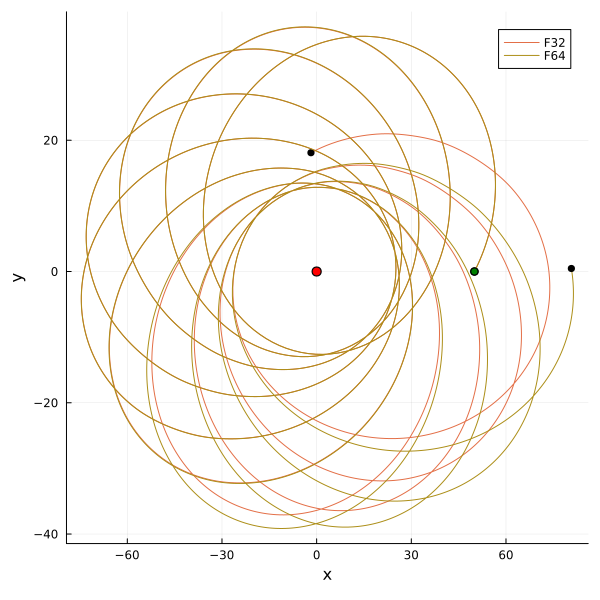

In [18]:
using Plots
import Parameters: @unpack
@unpack a = modelF64.parameters    #Get the BH spin parameter 

#Interpolate to higher resolution for smooth plotting   
interpolation_factor = 10 

Tend = min(last(solutionF64.t),last(solutionF32.t))
len = length(solutionF64.t)*interpolation_factor

Tspan = range(first(solutionF64.t),Tend,length=len)
p64  = solutionF64(Tspan)
p32  = solutionF32(Tspan)

xBH = 0:0; yBH = 0:0
plt = scatter(xBH, yBH,markercolor="red",markersize=5,size = (600, 600),xlabel='x', ylabel='y',label="")

labels = ["F32", "F64"]
i = 1
for p in [p32,p64]

    r = p[2,:]
    θ = p[3,:] 
    ϕ = p[4,:]

    # Boyer lindquist to Cartesian 
    w = sqrt.(r.^2 .+ a^2) 
    x = w .* sin.(θ) .* cos.(ϕ)
    y = w .* sin.(θ) .* sin.(ϕ)
    z = r .* cos.(θ)


    plt = plot!(x,y,label=labels[i])       
    plt = scatter!(first(x):first(x), first(y):first(y),markercolor = "green",label="") # The start point
    plt = scatter!(last(x):last(x), last(y):last(y),markercolor = "black",label="")     #The end point 
    i+=1

end 
display(plt)


## 3. Automatic Differentiation 

`RelativisticDynamics.jl` is written so as to be generally differentiable by the [differentiation tools in Julia](https://juliadiff.org/).

Specifically, we have been working using [Enzyme.jl](https://github.com/EnzymeAD/Enzyme.jl).

Let's see how this works by considering how the numerical solution varies with eccentricity. That is, want to calculate

$$\frac{\partial L}{\partial e} $$

where $L$ is some general loss function which depends on the output of `orbit()`.


To define our loss function, lets first get a reference solution:


In [19]:
# Get a reference solution.
# We will use this to define a gradient 
reference_solution,reference_model = orbit(Norbits=1); #using the default parameters

Given this reference solution, we define some arbitrary loss that compares the difference in the final value of the $r$-coordinate at the end of the integration.

In [25]:
function loss_function(reference,e)

    # Run the model using the new value of e
    solution,model = orbit(e=e,Norbits=1)
    

    r0 = last(reference[2,:])  # The last r value of the reference solution
    r = last(solution[2,:])    # The last r value of the new solution
    loss = abs(r0 - r)         # Loss
  
    return loss

end

loss_function (generic function with 1 method)

We can explore explicitly how this loss function varies with $e$:

In [26]:
N = 20 #number of samples
loss_data = zeros(Float64,N,2)
for (i,v) in pairs(range(0.1,0.9,N))

    loss = loss_function(reference_solution,v)
    loss_data[i,1] = v 
    loss_data[i,2] = loss

end

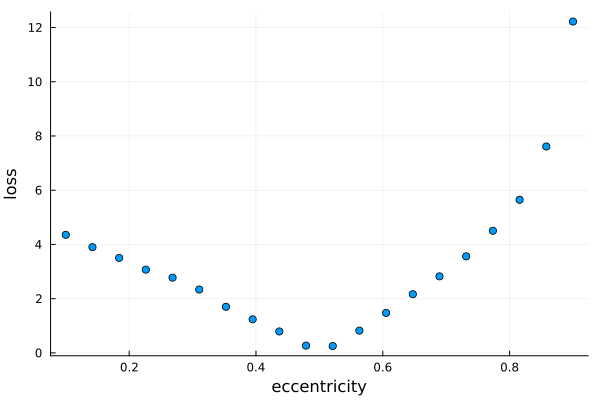

In [29]:
scatter(loss_data[:,1], loss_data[:,2],legend=false,
        xlabel = "eccentricity",
        ylabel = "loss") # eccentricity vs loss 

Ok that makes sense - the loss is minimal at $e=0.5$ which is the value used in the reference solution and then diverges at low/high $e$.

Now, suppose we have the reference solution, but we don't know the eccentricity.

We can guess some at some eccentricity and see how the solution compares to the reference i.e. calculate the loss.

But given this loss what do we do next? Guess a higher $e$? Lower $e$? By how much do we increase/decrease $e$? This is a classic optimization problem that - if we had a gradient - could be trivially solved by gradient descent. 

However, using AD we can also get the gradient of the solution!


## TODO: working example using ENZYME


In [18]:
using Enzyme 


#Enzyme.gradient = gradient(Forward, loss_function, reference_solution, 0.2)
 


Enzyme.autodiff(Forward, loss_function, Duplicated, reference_solution,Duplicated(0.2,1.0))


#.gradient(x -> loss_function(reference_solution,x),v)[1]


In [8]:
using Enzyme 

loss_gradient_data = zeros(Float64,N,2)
for (i,v) in pairs(range(0.1,0.9,N))
    loss_g = Zygote.gradient(x -> loss_function(reference_solution,x),v)[1]
    loss_gradient_data[i,1] = v 
    loss_gradient_data[i,2] = loss_g
end

UndefVarError: UndefVarError: N not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


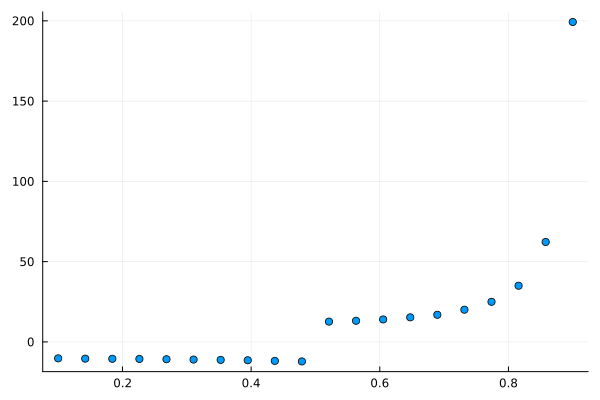

In [27]:
scatter(loss_gradient_data[:,1], loss_gradient_data[:,2],legend=false) # eccentricity vs gradient 